# Plant Disease Classifier

In [100]:
import tensorflow as tf
from tensorflow.keras  import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [60]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [61]:
#shuffle - True to randomly shuffle the images from our main directory
#image_size = (height of each image,width of each image)
#batch_size = Size of the batches of data. Default: 32.
dataset = tf.keras.preprocessing.image_dataset_from_directory( "PlantVillage",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [62]:
#Here , folder names inside the "PlantVillage directory are our class names present in the dataset"
print(dataset.class_names)
class_names = dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [63]:
#Showing the number of batches in the dataset 
#each batch contains 32 images 
#Actual size = 68 * 32 approx as last batch may have less than 32 image
len(dataset)

68

In [64]:
#image_batch.shape ---> (batch_size,image_height,image_width,rgb_channels)
#print(label_batch.numpy()) ----> Three classes representes using 0,1,2
#take(1) ---> Taking one batch of 32 images only from the dataset
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 2 1 2 1 2 0 2 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0]


In [65]:
CHANNELS = 3
EPOCHS = 50

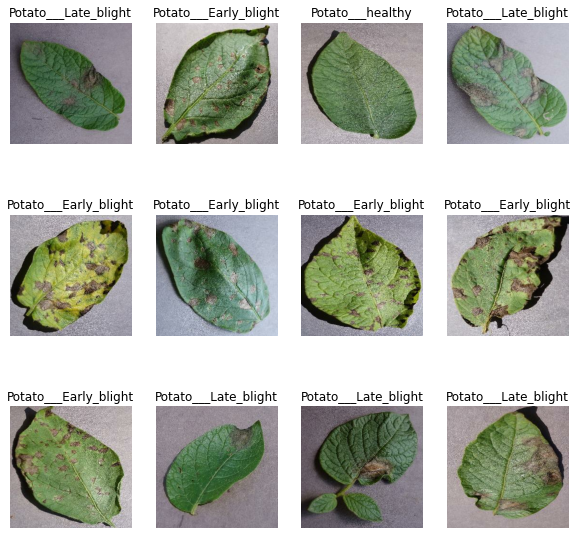

In [66]:
#image_batch[0].numpy() ---> image is represented using 3-D matrices of pixel value b/w 0-255
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i  in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#         print(image_batch[0].numpy())
    

In [67]:
# 80% data as training
# 10% data as validation , 10% test
train_size = 0.8
len(dataset)*0.8

54.400000000000006

In [68]:
#Taking the 54 batches as training data
train_ds = dataset.take(54)

In [69]:
len(train_ds)

54

In [70]:
#Taking the remaing other than 54 datsets as test data 
test_ds = dataset.skip(54)
len(test_ds)

14

In [71]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [72]:
val_ds = test_ds.take(6)

In [73]:
len(val_ds)

6

In [74]:
train_ds = test_ds.skip(6)
len(train_ds)

8

In [75]:
def get_dataset_split(dataset,train_split=0.8,val_split=0.1,shuffle = True , test_split=0.1,shuffle_size=10000):
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [76]:
train_ds,val_ds,test_ds = get_dataset_split(dataset)

In [77]:
len(train_ds)

54

In [78]:
print(f"{len(val_ds)} , {len(test_ds)}")

6 , 8


In [79]:
#Because of the cache(), the second iteration of the dataset will load data from the cache in memory
#instead than the previous steps of the pipeline.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [80]:
# dividing the pixel by 255 to get all the pixel value b/w 0-1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [81]:
#creating a data augmentation layer for a more robust model
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
 ])

In [82]:
input_shape=(BATCH_SIZE , IMAGE_SIZE,IMAGE_SIZE ,CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])

In [83]:
#Building the model
model.build(input_shape=input_shape)

In [84]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_7 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (32, 60, 60, 64)         

In [85]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [86]:
history = model.fit(train_ds,epochs = EPOCHS,batch_size = BATCH_SIZE,verbose = 1,validation_data = val_ds)

Epoch 1/50
54/54 [==============================] - 114s 2s/step - loss: 0.9070 - accuracy: 0.4890 - val_loss: 0.9708 - val_accuracy: 0.4062
Epoch 2/50
54/54 [==============================] - 114s 2s/step - loss: 0.7436 - accuracy: 0.6377 - val_loss: 0.7088 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 116s 2s/step - loss: 0.5214 - accuracy: 0.7795 - val_loss: 0.4143 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 115s 2s/step - loss: 0.4897 - accuracy: 0.7859 - val_loss: 0.4111 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 121s 2s/step - loss: 0.3649 - accuracy: 0.8582 - val_loss: 0.2439 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 116s 2s/step - loss: 0.2883 - accuracy: 0.8947 - val_loss: 0.2464 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 117s 2s/step - loss: 0.1952 - accuracy: 0.9225 - val_loss: 0.7584 - val_accuracy: 0.7500
Epoch 8/50
54

In [88]:
#Evaluating the model on the test dataset
prediction = model.evaluate(test_ds)
print(prediction)

8/8 [==============================] - 3s 324ms/step - loss: 0.0690 - accuracy: 0.9648
[0.06895216554403305, 0.96484375]


In [89]:
#We got an accuracy of approx 97%
print(f"The Accuracy of the model on the test dataset is: {prediction[1]}")

The Accuracy of the model on the test dataset is: 0.96484375


In [90]:
history

In [91]:
history.history

{'loss': [0.906975269317627,
  0.7436278462409973,
  0.5213805437088013,
  0.4897472858428955,
  0.36494994163513184,
  0.28829577565193176,
  0.19515419006347656,
  0.321428507566452,
  0.17607252299785614,
  0.15686573088169098,
  0.12897039949893951,
  0.10454660654067993,
  0.11585715413093567,
  0.09884609282016754,
  0.08177299797534943,
  0.08429539948701859,
  0.06612876057624817,
  0.07739574462175369,
  0.12694518268108368,
  0.07098349183797836,
  0.04982366785407066,
  0.0608740895986557,
  0.07415919750928879,
  0.09915579855442047,
  0.15058869123458862,
  0.06786826252937317,
  0.06223365291953087,
  0.03624112531542778,
  0.028132954612374306,
  0.0488845519721508,
  0.02923586778342724,
  0.02776898257434368,
  0.03766555339097977,
  0.06909500062465668,
  0.025538993999361992,
  0.02034815214574337,
  0.018787948414683342,
  0.03986048698425293,
  0.05212387815117836,
  0.0314229317009449,
  0.02078475058078766,
  0.019364533945918083,
  0.08504095673561096,
  0.05082

In [93]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [94]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

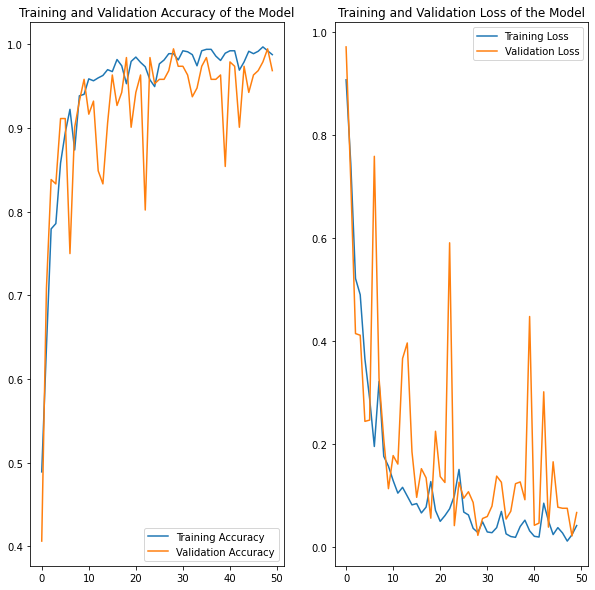

In [97]:
#plotting the graph
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of the Model')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of the Model')
plt.show()

first image to predict
Actual label of the image :  Potato___Late_blight
Predicted label of the image by our model :  Potato___Late_blight


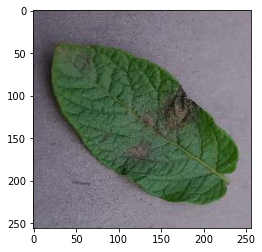

In [101]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label of the image : ",class_names[first_label])
    #As predict() requires a batch of images for prediction.
    batch_prediction = model.predict(images_batch)
    print("Predicted label of the image by our model : ",class_names[np.argmax(batch_prediction[0])])
    
    

In [118]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

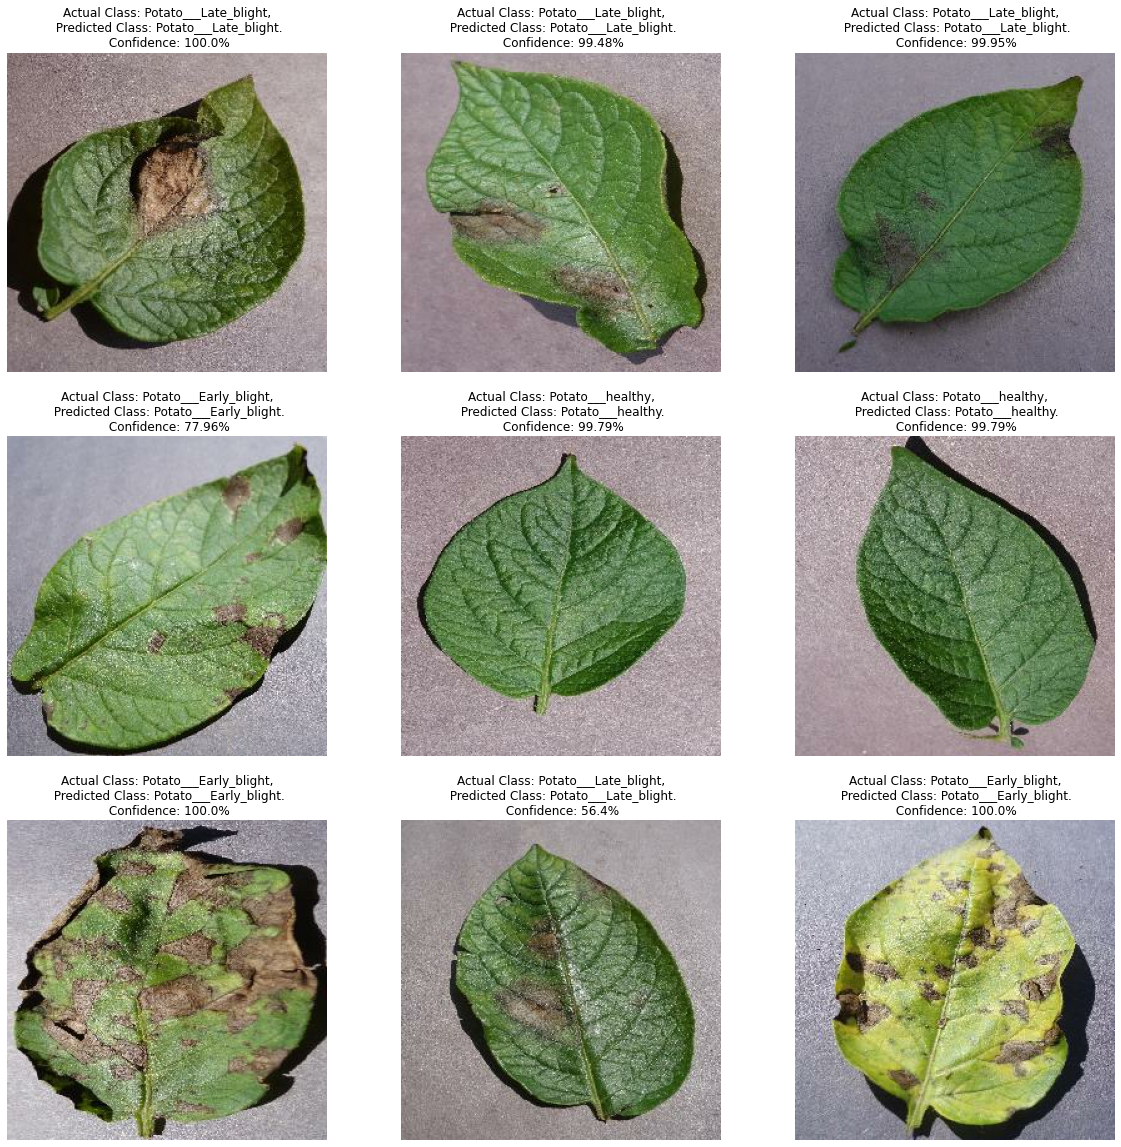

In [121]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model to our system

In [123]:
model_version = 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets
